In [1]:
from fastai.vision.all import *

In [3]:
import torch

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
def parent_label_list(o):
    """
    Returns the parent label of the image as a list
    This is required for a Miltilabel classification problem

    Args:
        o (_type_): _description_

    Returns:
        _type_: _description_
    """
    label = parent_label(o)
    grand_parent_label = o.parent.parent.name
    if label == 'not-a-pet':
        return [label]
    
    return [grand_parent_label[:-1], label]


In [5]:
# Define the CustomHead class with shape inspection
class CustomHead(nn.Module):
    def __init__(self, nf, n_out):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(nf, n_out)

    def forward(self, x):
        if x.dim() == 2:  # No spatial dimensions (1D features per image)
            # print("Input is 2D, skipping pooling.")
            x = self.flatten(x)
        elif x.dim() == 4:  # Regular case: [batch_size, channels, height, width]
            x = self.pool(x)
            # print(f"Shape after pooling: {x.shape}")
            x = self.flatten(x)
        else:
            raise ValueError(f"Unexpected input dimension: {x.dim()} dimensions.")
        # print(f"Shape after flattening: {x.shape}")
        x = self.linear(x)
        return x


In [7]:
def custom_accuracy(y_pred, y_true, thresh=0.2, sigmoid=True):
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred > thresh) == y_true.bool()).float().mean()


In [20]:
learn = load_learner('xresnet50.pkl')
learn.dls.device = device

In [21]:
from fastai.vision.all import PILImage
from PIL import Image
import numpy as np

# Debug: Check if learn object is loaded
try:
    print(f"Model loaded: {learn}")
except NameError:
    print("Error: 'learn' object is not defined or not loaded.")

# Debug: Check if dls object is loaded
try:
    print(f"DataLoaders loaded: {learn.dls}")
    print(f"Vocabulary: {learn.dls.vocab}")
except NameError:
    print("Error: 'dls' object is not defined or not loaded.")
except AttributeError:
    print("Error: 'dls' object does not have the expected attributes.")



Model loaded: <fastai.learner.Learner object at 0x7fe5847058d0>
DataLoaders loaded: <fastai.data.core.DataLoaders object at 0x7fe594137150>
Vocabulary: ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 'Khao Manee', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Munchkin', 'Norwegian Forest Cat', 'Ocicat', 'Oriental Shorthair', 'Persian', 'Peterbald', 'Ragdoll', 'Russian Blue', 'Savannah', 'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Snowshoe', 'Somali', 'Sphynx', 'Tonkinese', 'Toyger', 'Turkish Angora', 'Turkish Van', 'cat', 'not-a-pet']


In [32]:
def perform_prediction(img_path, show_image=True, threshold=0.2):
    try:
        img = PILImage.create(img_path)
        if show_image: img.show()
        
        # Convert the PILImage to a PyTorch tensor and move it to the same device as the learner
        img_tensor = learn.dls.test_dl([img]).one_batch()[0].to(device)
    except Exception as e:
        print(f"Error loading image: {e}")

    # Predict on a new image
    try:
        learn.model = learn.model.to(device)  # Move model to GPU if available
        pred, pred_idx, probs = learn.predict(img)
        probs = sigmoid(probs)
        # preds, _ = learn.tta(dl=learn.dls.test_dl([img]))
        # probs = sigmoid(preds.mean(dim=0))
    except Exception as e:
        print(f"Error in prediction: {e}")

    # Get indices of labels that exceed the threshold
    predicted_indices = (probs > threshold).nonzero(as_tuple=True)[0]

    # Retrieve the corresponding probabilities
    predicted_probs = probs[predicted_indices]

    # Sort the indices based on the probabilities in descending order
    sorted_indices = predicted_indices[predicted_probs.argsort(descending=True)]

    # Retrieve the sorted labels and probabilities
    sorted_labels = [learn.dls.vocab[i] for i in sorted_indices]
    sorted_probs = probs[sorted_indices]

    # Format the output as a list of tuples
    result = [(label, prob.item()) for \
        label, prob in zip(sorted_labels, sorted_probs)]

    return (result, probs, learn.dls.vocab)

In [33]:
def perform_validation_on_a_batch(path=Path("inputs/processed/test"), n=5, threshold=0.2):
    """Get n random images from each folder in the path and perform a prediction on each image.

    Args:
        path (_type_, optional): _description_. Defaults to Path("training").
        n (int, optional): _description_. Defaults to 5.
    """
    if path:
        validation_path = path

    # Get all folders recursively
    all_folders = [f for f in validation_path.rglob('*') if f.is_dir()]

    # Filter out parent directories that have subdirectories
    folders = [f for f in all_folders if not any(sub.is_dir() for sub in f.iterdir())]

    results = []
    #iterate through each folder
    for folder in folders:
        all_files = folder.ls()
        
        # Filter the list to include only .jpg files
        jpg_files = L([file for file in all_files if file.suffix.lower() == '.jpg']).sorted()

        # Shuffle the filtered list and select the first n images
        if n is None:
            images = jpg_files
        else:
            images = jpg_files.shuffle()[:n]

        for img_path in images:
            result, probs, vocab = perform_prediction(
                img_path,
                show_image=False,
                threshold=threshold)
            #check that folder.name is in the result using lower case
            
            labels_to_check = []
            labels_to_check.append(folder.name.lower())
            if not folder.parent.name in ['test', 'train', 'valid']:
                grand_parent_folder_name = folder.parent.name.lower()[:-1]   # Strip plural 's' if needed
                labels_to_check.append(grand_parent_folder_name)
            
            # Ensure all these labels are in the result
            result_labels = [item[0].lower() for item in result]  # Convert result labels to lower case

            # Ensure all labels in `labels_to_check` are present in the prediction results
            is_correct = all(label in result_labels for label in labels_to_check)

            folder_idx_in_vocab = vocab.o2i[folder.name]
            folder_probability = probs[folder_idx_in_vocab].item()

            # place the results in a dataset to view later
            results.append({
                'Folder': folder.name,
                'Image': img_path.name,
                'Result': result,
                'Correct': is_correct,
                'FolderName Probability': folder_probability            
            })        
            
            # print(f"Image: {img_path.name}, Result: {result}, Correct: {is_correct}")
    
    return results    


In [34]:
def display_results(results):
    # calculate the accuracy
    correct_results = [result['Correct'] for result in results]
    accuracy = sum(correct_results) / len(correct_results)
    print("Validation complete - Accuracy: ", accuracy)

    # loop through tuples in results[result] and format the second item to be 2 decimal places
    for result in results:
        for i, item in enumerate(result['Result']):
            result['Result'][i] = (item[0], round(item[1], 2))    
            
    # Convert the list of results to a pandas DataFrame
    results_df = pd.DataFrame(results)

    # ensure the whole DataFrame is displayed
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    
    # Display the DataFrame
    display(results_df)        

In [35]:
display_results( \
    perform_validation_on_a_batch( \
        path=Path("inputs/processed/test"), 
        threshold=0.2,
        n=1))

Validation complete - Accuracy:  0.3695652173913043


,Folder,Image,Result,Correct,FolderName Probability
0,not-a-pet,b8093bb9-87e3-4387-9f66-c005893b1bca.jpg,"[(not-a-pet, 0.99)]",True,0.987633
1,Abyssinian,322585ee-bfa3-41cc-86e7-2a5a7b58f991.jpg,"[(cat, 1.0), (Abyssinian, 0.74)]",True,0.740942
2,American Bobtail,2148e5dc-ce06-4b49-9114-371a866fefe9.jpg,"[(cat, 1.0), (American Bobtail, 0.23)]",True,0.227949
3,American Curl,21dea7da-f3e1-43a2-8f67-2528d68cbb7d.jpg,"[(cat, 1.0)]",False,0.044618
4,American Shorthair,3bfe4bd6-157a-4524-b9d0-733d16fb2bb5.jpg,"[(cat, 1.0)]",False,0.178776
5,American Wirehair,2c4496ac-717c-48c7-9d03-ee2ca72f0f8f.jpg,"[(cat, 1.0)]",False,0.075488
6,Balinese,0a2b0bba-c21e-46ca-8093-220470443d02.jpg,"[(cat, 0.99), (Khao Manee, 0.31)]",False,0.015962
7,Bengal,302637d5-3faf-44de-b9ca-ecbc8ea8886e.jpg,"[(cat, 1.0)]",False,0.022745
8,Birman,1d014bbb-3bbe-4c52-914d-450887e8e22e.jpg,"[(cat, 1.0), (Ragdoll, 0.44)]",False,0.148105
9,Bombay,0c0a24b0-24af-4d6d-b2fd-b91b42704cba.jpg,"[(cat, 1.0), (Bombay, 0.94)]",True,0.937873


In [188]:
display_results(perform_validation_on_a_batch(path=Path("inputs/processed/valid"), n=1))

Validation complete - Accuracy:  0.8478260869565217


,Folder,Image,Result,Correct,FolderName Probability
0,not-a-pet,12ba530f-cc64-4a22-a6aa-3785928f6d5f.jpg,"[(not-a-pet, 1.0)]",True,9.999969e-01
1,Abyssinian,80a081e9-1215-45cd-9ba4-6dc3fa2508eb.jpg,"[(cat, 1.0), (Abyssinian, 1.0)]",True,9.966987e-01
2,American Bobtail,94539190-dbfb-438f-9f16-ada3c8e7f0ff.jpg,"[(cat, 1.0), (American Bobtail, 0.99)]",True,9.930386e-01
3,American Curl,645b9d9c-7808-446a-92bd-aa3f25f214e2.jpg,"[(cat, 1.0), (American Curl, 1.0)]",True,9.976841e-01
4,American Shorthair,1c440f90-2884-4659-9c0a-8b70a38114a7.jpg,"[(cat, 1.0), (American Shorthair, 0.99)]",True,9.871653e-01
5,American Wirehair,2fe58588-85c0-4eee-a371-96ea54585bac.jpg,"[(cat, 1.0), (Turkish Van, 0.94)]",False,4.652964e-02
6,Balinese,9ade07bf-ba17-4721-8445-e1b02e8ca24e.jpg,"[(cat, 1.0), (Balinese, 1.0)]",True,9.958941e-01
7,Bengal,781811c6-708a-4460-bc01-d4a48e4b998a.jpg,"[(cat, 1.0), (Bengal, 0.99)]",True,9.932834e-01
8,Birman,52f1dccd-a6f1-4542-a77f-989848d686d8.jpg,"[(cat, 1.0), (Birman, 0.99)]",True,9.940586e-01
9,Bombay,d2ba4511-d8ae-4f70-b3dc-2c71baad3a7f.jpg,"[(cat, 1.0), (Bombay, 1.0)]",True,9.971705e-01


In [189]:
display_results(perform_validation_on_a_batch(path=Path("inputs/processed/train"), n=1))

Validation complete - Accuracy:  0.9782608695652174


,Folder,Image,Result,Correct,FolderName Probability
0,not-a-pet,dca00877-b54a-44de-8677-fbb56a8ad741.jpg,"[(not-a-pet, 1.0)]",True,0.999989
1,Abyssinian,1aa53f01-8c20-4572-aa0b-c3f28054786f.jpg,"[(cat, 1.0), (Abyssinian, 1.0)]",True,0.996941
2,American Bobtail,b9dae0c8-edc6-4721-a0fc-0a33f184e440.jpg,"[(cat, 1.0), (American Bobtail, 1.0)]",True,0.998370
3,American Curl,0ed3a46f-c3dd-4d73-bb3f-0df235aade3e.jpg,"[(cat, 1.0), (American Curl, 1.0)]",True,0.999170
4,American Shorthair,207e2438-20e9-45b1-9e96-6780ae956144.jpg,"[(cat, 1.0), (American Shorthair, 0.98)]",True,0.983776
5,American Wirehair,4a491a35-662c-44ab-a65c-87d2f3d0a9bb.jpg,"[(cat, 1.0), (American Wirehair, 1.0)]",True,0.999459
6,Balinese,4e82fab9-a190-4a8c-939d-e02da6b54ee2.jpg,"[(cat, 1.0), (Balinese, 1.0)]",True,0.999243
7,Bengal,73ebe9dc-ab25-4d97-9cd8-308fc9309c04.jpg,"[(cat, 1.0), (Bengal, 1.0)]",True,0.997451
8,Birman,02aa164b-7c2e-47c7-9d59-bfaa2170ea34.jpg,"[(cat, 1.0), (Birman, 1.0)]",True,0.997146
9,Bombay,d79189cb-3f16-41d0-89d5-2881b22813b4.jpg,"[(cat, 1.0), (Bombay, 1.0)]",True,0.998585


([('cat', 0.9999994039535522), ('Abyssinian', 0.9970874190330505)],
 tensor([9.9709e-01, 1.0000e-07, 3.1169e-06, 1.5849e-04, 2.8270e-06, 1.5876e-07,
         1.2524e-05, 4.8886e-07, 2.8484e-06, 1.0000e-07, 3.9709e-05, 1.2660e-05,
         4.5692e-06, 1.0733e-05, 5.7882e-07, 1.1636e-04, 4.1359e-06, 6.5582e-04,
         5.4023e-06, 1.2134e-06, 1.7724e-05, 4.3580e-07, 1.4882e-07, 7.1077e-06,
         2.8602e-06, 1.5343e-07, 5.5858e-03, 1.9590e-04, 3.9195e-06, 1.6840e-05,
         1.0000e-07, 1.5907e-05, 1.3451e-05, 1.0201e-05, 1.4604e-07, 4.8830e-07,
         1.2028e-07, 2.5383e-04, 1.3920e-05, 1.3470e-06, 1.0000e-07, 9.3342e-05,
         7.3017e-06, 1.0000e-07, 1.0982e-07, 1.0000e+00, 5.2795e-07]),
 ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 

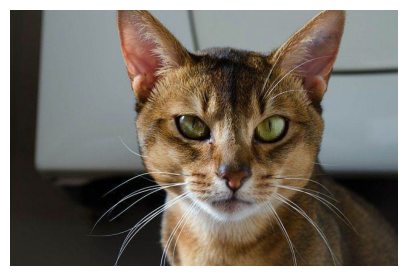

In [190]:
# Initial Validation on random image from training set
perform_prediction("inputs/processed/test/cats/Abyssinian/0a16dc6f-0757-42b2-a88b-5baef4cdc8d6.jpg")

([('not-a-pet', 0.999994158744812)],
 tensor([1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 2.1801e-07, 1.0000e-07,
         1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7886e-07,
         1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07, 1.7830e-07,
         1.0000e-07, 1.0000e-07, 1.0000e-07, 1.1752e-07, 1.0000e-07, 1.0000e-07,
         1.0000e-07, 1.0000e-07, 4.8350e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07,
         1.0000e-07, 1.0000e-07, 1.8793e-07, 1.0000e-07, 1.0000e-07, 1.0000e-07,
         2.5083e-06, 1.0000e-07, 1.0000e-07, 1.0000e-07, 4.5438e-07, 1.0000e-07,
         1.0000e-07, 1.0000e-07, 1.0000e-07, 6.6426e-06, 9.9999e-01]),
 ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 'Khao Manee', 'LaPerm', 'Lykoi'

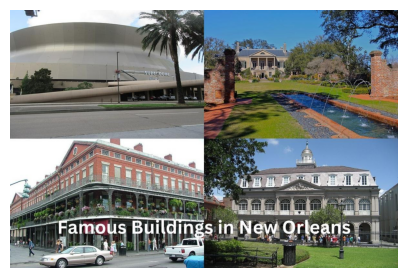

In [191]:
# Initial Validation on random image from training set
perform_prediction("inputs/processed/test/not-a-pet/0a65b83b-985e-4a2d-9603-3c49377136fb.jpg")


In [192]:
# Initial Validation on random image from training set
# perform_prediction("test")


In [193]:
img_path = Path('test/Abyssinian/05a5a708-5a74-40b3-826c-2cc47b6a50c0.jpg')
print(perform_prediction(img_path))


Error loading image: [Errno 2] No such file or directory: '/mnt/s/study/fastai_cat_clasifier/test/Abyssinian/05a5a708-5a74-40b3-826c-2cc47b6a50c0.jpg'
Error in prediction: cannot access local variable 'img' where it is not associated with a value


UnboundLocalError: cannot access local variable 'probs' where it is not associated with a value